Centering Kernel Matrix, please wait
Centering complete
Calculating sigs
Calculating zPrimes


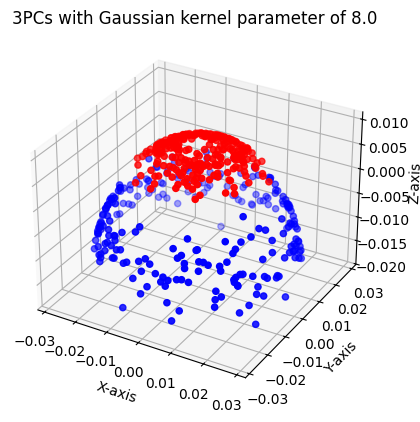

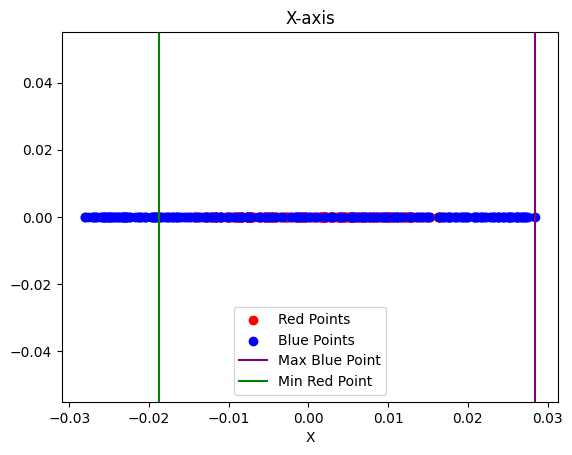

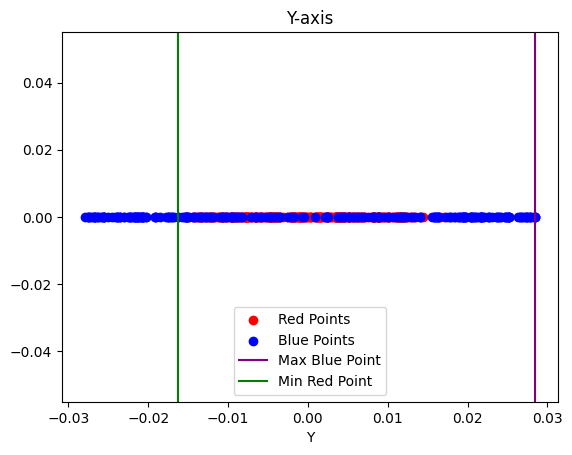

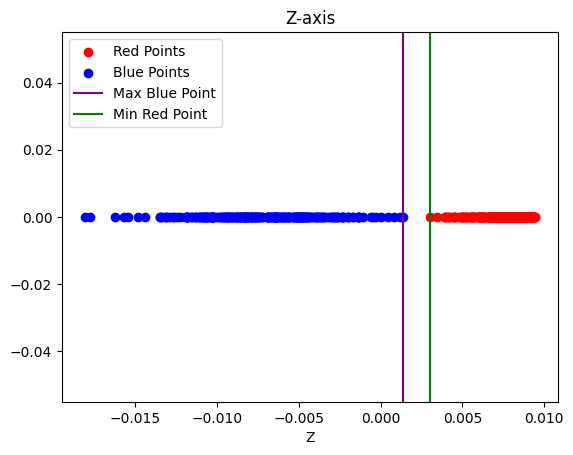

LINEARLY SEPARABLE ON Z AXIS (PC number 3) USING DECISION STUMP: if value of Z dimension of point <0.0022163656705906595 label point 2 for blue, else 1 for red


In [2]:
import math
import pandas as pd
import matplotlib.pyplot as plt
from numpy import linalg as LA
from mpl_toolkits.mplot3d import Axes3D
import numpy as np


# Set data file to read
temp = pd.read_csv('circles.data', names=['x', 'y', 'label'] )
circlesData = temp.copy()


#Set how many top PCs to use, the kernel function (0=polynomial, 1=gausian) and corresponding hyperparameter
hyperParam = 8.0
kernelOption = 1
topPCs = 3 #only working for up to 3 PCs as 3 was adequate for linear classification

circlesDataList = circlesData.values.tolist()


# Inner product helper function
def innerProd(item1x, item1y, item2x, item2y):
    return (item1x*item2x+item1y*item2y)**hyperParam


# Polynomial kernel function
def kernelPoly(circlesDataList):
    
    kernelMatrix = [[]]

    i=0
    j=0
    while i < len(circlesDataList):
        kernelMatrix.append([])
        while j < len(circlesDataList):
            kernelMatrix[i].append([])
            kernelMatrix[i][j] = innerProd(circlesDataList[i][0], 
                                        circlesDataList[i][1], 
                                        circlesDataList[j][0], 
                                        circlesDataList[j][1])
            j+=1
        j=0
        i+=1

    return kernelMatrix

# Gaussian kernel helper function
def gausCalc(row1, row2):
    row1len = len(row1)
    a=0
    sum1=0
    while a < row1len:

        sum1 += (row1[a]-row2[a])**2

        a+=1
    return math.sqrt(sum1)

# Gaussian kernel function
def kernelGaus(circlesDataList):
    
    gam = 1.0 / (2.0 * hyperParam**2)
    
    
    kernelMatrix = [[]]
    i=0
    j=0
    while i < len(circlesDataList):
        kernelMatrix.append([])
        while j < len(circlesDataList):
            kernelMatrix[i].append([])
            
            kernelMatrix[i][j] = math.exp(-gam*gausCalc(circlesDataList[i], circlesDataList[j])**2)
            
            j+=1
        j=0
        i+=1
    
    return kernelMatrix


kernelName = ''

kernelMatrix = [[]]

# Apply the kernel function of choice to the dataset
if kernelOption == 0:
    kernelMatrix = kernelPoly(circlesDataList)
    kernelName = 'Polynomial'
else:
    kernelMatrix = kernelGaus(circlesDataList)
    kernelName = 'Gaussian'

# Helper function for kernel centering 
def centerSum(kernelMatrixIindex, kernelMatrix):
    
    l=0
    sum=0
    while l < len(kernelMatrix[kernelMatrixIindex]):
        sum+=kernelMatrix[kernelMatrixIindex][l]
        l+=1
    return sum

# Helper function for kernel centering 
def centerSumSum(kernelMatrix):
    p=0
    q=0
    sum=0
    while p < len(kernelMatrix):
        while q < len(kernelMatrix[p]):
            sum += kernelMatrix[p][q]
            q+=1
        q=0
        p+=1
    return sum

def kernelCenter(kernelMatrix):
    centeredKernelMatrix = [[]]
    i=0
    j=0
    n=len(kernelMatrix)+1
    ksum = centerSumSum(kernelMatrix)
    while i < len(kernelMatrix):
        centeredKernelMatrix.append([])
        while j < len(kernelMatrix[i]):
            centeredKernelMatrix[i].append([])
            
            kij = kernelMatrix[i][j]
            
            sum1 = (1/n)*centerSum(i, kernelMatrix)
            
            sum2 = (1/n)*centerSum(j, kernelMatrix)
            
            sumsum3 = (1/n**2)*ksum
            
            # Centering equation given
            centeredKernelMatrix[i][j] = kij - sum1 - sum2 + sumsum3
            j+=1
        j=0
        i+=1
        

    return centeredKernelMatrix

kernelMatrixDF = pd.DataFrame(kernelMatrix) 


# Centering algorithm for kernel matrix
print('Centering Kernel Matrix, please wait')
centeredKernelMatrix = kernelCenter(kernelMatrix)
print('Centering complete')

centeredKernelMatrixDF = pd.DataFrame(centeredKernelMatrix) 
centeredKernelMatrixDF = centeredKernelMatrixDF.drop(centeredKernelMatrixDF.index[-1])
centeredKernelMatrixDF = centeredKernelMatrixDF.drop(centeredKernelMatrixDF.index[-1])

# Eigen decomposition
eigenvalues, eigenvectors = np.linalg.eigh(centeredKernelMatrixDF)

# Formulas:

# Z'c = (K * Uc) / small sigma c

# small sigma c = sqrt ((n-1) epsilon c)

# episilon c = cth eigenvalue of K

eigenvectorsDF = pd.DataFrame(eigenvectors)


#Calculate values of Sigma
print('Calculating sigs')
sigs = []
for i in range(len(centeredKernelMatrixDF)):
    sigs.append(np.sqrt((len(centeredKernelMatrixDF)-1)*np.abs(eigenvalues[i])))


# Calculate columns of Z'
print('Calculating zPrimes')
zPrimes = []
for i in range(500):
    zPrimes.append((centeredKernelMatrixDF @ eigenvectorsDF.iloc[:, i:i+1]) / sigs[i])


# Calculate varience
variances = [np.var(np.array(x)) for x in zPrimes]


# Use varience to find a projection matrix that uses the top i PCs
bestPCs = []
for i in range(topPCs):
    bestPCs.append(np.argmax(variances))
    variances[bestPCs[i]] = -5


# Construct the Z' projection matrix
zPrimeCombined = pd.DataFrame(zPrimes[bestPCs[0]])
for i in range(len(bestPCs)):
    if i != 0:
        zPrimeCombined = pd.concat([zPrimeCombined, zPrimes[bestPCs[i]]], axis = 1)

# Add back the label column from original dataset
zPrimeCombinedLabeled = pd.concat([zPrimeCombined, circlesData.iloc[:, -1:]], axis=1)



#Scatter graph plotting

newColumnLabels = []
if topPCs == 1:
    # Set the 1 column name of Z' + the label column, 1D graph gets plotted further down
    zPrimeCombinedLabeled.columns = ['X', 'label']
    colour = zPrimeCombinedLabeled.label.map({1:'r', 2:'b'})
    
elif topPCs == 2:
    # Set the 2 column names of Z' + the label column and plot a 2D scatter graph
    
    zPrimeCombinedLabeled.columns = ['X', 'Y', 'label']
    colour = zPrimeCombinedLabeled.label.map({1:'r', 2:'b'})
    plt.scatter(zPrimeCombinedLabeled['X'], zPrimeCombinedLabeled['Y'], c=colour, marker='o')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    
    plt.title('2PCs with ' + kernelName + ' kernel parameter of '+ str(hyperParam))
    plt.show()
    
elif topPCs == 3:
    # Set the 3 column names of Z' + the label column and plot a 3D scatter graph
    
    zPrimeCombinedLabeled.columns = ['X', 'Y', 'Z', 'label']
    colour = zPrimeCombinedLabeled.label.map({1:'r', 2:'b'})
    
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    ax.set_zlabel('Z-axis')

    scatter = ax.scatter(zPrimeCombinedLabeled['X'], zPrimeCombinedLabeled['Y'], zPrimeCombinedLabeled['Z'], c=colour, marker='o')

    plt.title('3PCs with ' + kernelName + ' kernel parameter of '+ str(hyperParam))
    plt.show()


# Plot 1D scatter graphs for each PC axis
selected_column = ''
linearSeparationFound = False
for i in range(topPCs):
    
    # Set axis for iteration of i
    if i == 0:
        selected_column = 'X'
    elif i == 1:
        selected_column = 'Y'
    elif i == 2:
        selected_column = 'Z'

    # Separate the data into red and blue points
    red_points = zPrimeCombinedLabeled[zPrimeCombinedLabeled['label'] == 1]
    blue_points = zPrimeCombinedLabeled[zPrimeCombinedLabeled['label'] == 2]


    # Find the maximum blue value and the minimum red value
    min_red_point = red_points.loc[red_points[selected_column].idxmin()]
    max_blue_point = blue_points.loc[blue_points[selected_column].idxmax()]


    # Create a scatter plot
    plt.scatter(red_points[selected_column], [0] * len(red_points), color='red', label='Red Points')
    plt.scatter(blue_points[selected_column], [0] * len(blue_points), color='blue', label='Blue Points')

    # Draw a normal line through the point with the maximum value in the selected column for blue points
    plt.axvline(x=max_blue_point[selected_column], color='purple', linestyle='solid', label='Max Blue Point')
    plt.axvline(x=min_red_point[selected_column], color='green', linestyle='solid', label='Min Red Point')


    # Add labels and legend
    plt.xlabel(selected_column)
    plt.title(selected_column + '-axis')
    plt.legend()

    plt.show()
    
    # Detect if linear separation has been achieved
    if max_blue_point[selected_column] < min_red_point[selected_column]:
        linearSeparationFound = True
        
        # Calculate midpoint between max blue and min red point for decision stump value
        decisionStump = (max_blue_point[selected_column] + min_red_point[selected_column]) / 2
        
        print('LINEARLY SEPARABLE ON ' + selected_column + ' AXIS (PC number '+ str(i+1) +') USING DECISION STUMP: if value of Z dimension of point <' + str(decisionStump) + ' label point 2 for blue, else 1 for red')

if linearSeparationFound == False:
    print('No decision stump for linear separation found for ' + str(topPCs) + ' top PC(s), ' + kernelName + ' kernel function and a hyperparameter of ' + str(hyperParam))


